# Forecasting Sales
We are given a series of sales data and the corresponding sales budgets we wish to achieve at the same time. We would like to tell the future and predict that whether we will hit our expected volume of sales / sales budget in the upcoming months.

In [177]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
df = pd.read_excel('monthly_sales.xlsx')
df.head()

,Month,Sales,Budget
0,2014-01-01,14840.0,13740.0
1,2014-02-01,14820.0,16466.0
2,2014-03-01,17920.0,18474.0
3,2014-04-01,19020.0,17449.0
4,2014-05-01,20600.0,22150.0


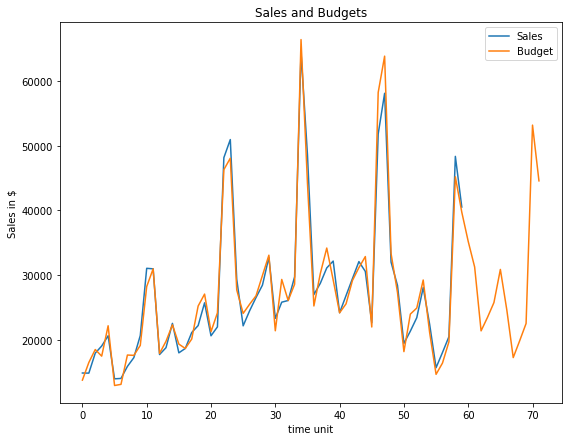

In [179]:
## larger figures
plt.rcParams['figure.figsize'] = [9, 7]

sales_df = df[['Sales']];
budget_df = df[['Budget']];

plt.plot(sales_df, label='Sales');
plt.plot(budget_df, label='Budget');
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('Sales and Budgets')
plt.legend();

In [180]:
sales = sales_df.dropna().to_numpy()
budget = budget_df.to_numpy()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(sales)

In [181]:
global SET_SIZE;

def generate_x_y(data, size, length):
    x_data = np.zeros((length - size, size), dtype=float)
    y_data = np.zeros((length - size, 1), dtype=float)
    for i in range(size-1, length):
        segment = data[np.arange(i - size, i)]
        x_data[i - size] = np.reshape(segment, (-1, size))
        y_data[i - size] = data[i]
    return x_data, y_data

In [182]:
SET_SIZE = 5
x_data, y_data = generate_x_y(data, SET_SIZE, data.shape[0])

In [183]:
def shuffle_x_y(x_data, y_data):
    index = np.arange(x_data.shape[0])
    np.random.shuffle(index)
    x_random = np.zeros(x_data.shape)
    y_random = np.zeros(y_data.shape)
    for i in range(index.shape[0]):
        x_random[i] = x_data[index[i]]
        y_random[i] = y_data[index[i]]
    return x_random, y_random

x_data, y_data = shuffle_x_y(x_data, y_data)

In [184]:
from tensorflow.keras import layers, models

my_model = models.Sequential([
    layers.LSTM(SET_SIZE, return_sequences=True, input_shape=(SET_SIZE, 1)),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16),
    layers.Dense(64),
    layers.Dense(32),
    layers.Dense(1)
])
    
my_model.compile(optimizer='adam', loss='mae')

my_model.fit(np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1)),
             y_data, epochs=20, shuffle=True);

Train on 55 samples
Epoch 1/20
55/55 [==============================] - 4s 80ms/sample - loss: 0.2738
Epoch 2/20
55/55 [==============================] - 0s 717us/sample - loss: 0.2401
Epoch 3/20
55/55 [==============================] - 0s 731us/sample - loss: 0.2078
Epoch 4/20
55/55 [==============================] - 0s 709us/sample - loss: 0.1743
Epoch 5/20
55/55 [==============================] - 0s 658us/sample - loss: 0.1550
Epoch 6/20
55/55 [==============================] - 0s 798us/sample - loss: 0.1490
Epoch 7/20
55/55 [==============================] - 0s 742us/sample - loss: 0.1613
Epoch 8/20
55/55 [==============================] - 0s 638us/sample - loss: 0.1670
Epoch 9/20
55/55 [==============================] - 0s 735us/sample - loss: 0.1622
Epoch 10/20
55/55 [==============================] - 0s 836us/sample - loss: 0.1561
Epoch 11/20
55/55 [==============================] - 0s 583us/sample - loss: 0.1517
Epoch 12/20
55/55 [==============================] - 0s 939us/samp

In [185]:
new_sales = np.append(sales, np.zeros(budget.shape[0] - sales.shape[0]))
for i in range(sales.shape[0], new_sales.shape[0]):
    sample = new_sales[i - SET_SIZE:i]
    sample = scaler.transform(np.reshape(sample, (sample.shape[0], -1)))
    new_sales[i] = my_model.predict(np.reshape(sample, (1, sample.shape[0], 1)))[0, 0]
    new_sales[i] = scaler.inverse_transform(np.reshape(new_sales[i], (-1, 1)))

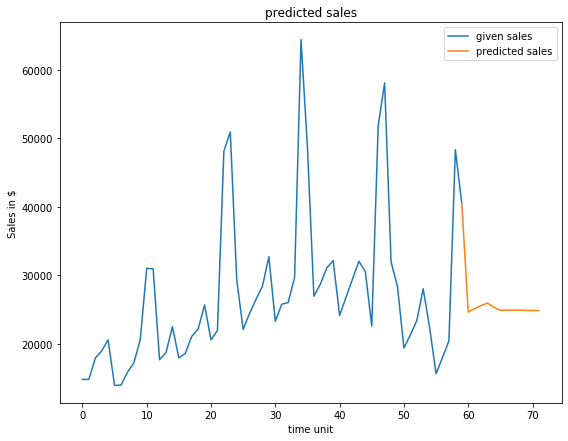

In [186]:
plt.plot(np.arange(sales.shape[0]), sales, label='given sales');
plt.plot(np.arange(sales.shape[0] - 1, new_sales.shape[0]), 
         new_sales[sales.shape[0] - 1: new_sales.shape[0]], label='predicted sales')
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('predicted sales');
plt.legend();

Our prediction is **fair and reasonable**, as we do see decreasing sales with the given data. The general trend looks much like a concaved-down quadratic curve. And the parts we are predicting mostly lies on the decreasing part of the curve.

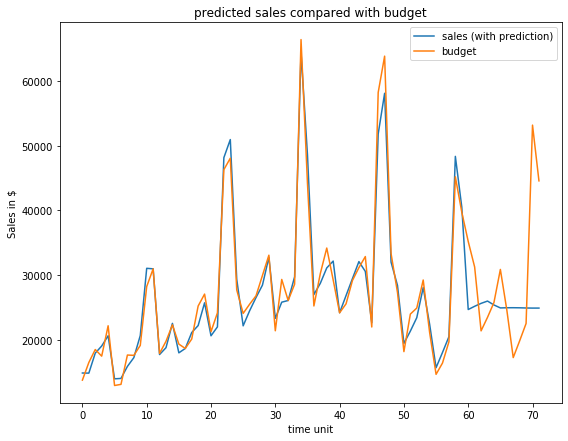

In [187]:
plt.plot(np.arange(new_sales.shape[0]), new_sales, label='sales (with prediction)');
plt.plot(np.arange(budget.shape[0]), budget, label='budget');
plt.xlabel('time unit');
plt.ylabel('Sales in $');
plt.title('predicted sales compared with budget');
plt.legend();

So, in conclusion, we **will not achieve our sales budget**, and is by a large amount.